# Import packages

In [1]:
import os
import random
from collections import Counter
from fractions import Fraction

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from music21 import converter, instrument, note, chord, stream

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD# If mounting Google Drive:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# If mounting Google Drive:

In [ ]:
# Mount Google Drive if files are on Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Parse MIDI files

In [2]:
ALLOWED_DURATIONS = [0.25, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]

def parse_midi_files(midi_folder):

    pitch_flat = []     # "C4", "E4.G4", etc.
    all_pitch_seqs = []     # [[song1_pitch], [song2_pitch], ...]
    all_duration_seqs = []  # [[song1_dur], [song2_dur], ...]

    for file in os.listdir(midi_folder):
        if file.endswith(".mid") or file.endswith(".midi"):
            try:
                midi = converter.parse(os.path.join(midi_folder, file))
                print(f"Parsing {file}")
                pitches = []
                durations = []

                parts = instrument.partitionByInstrument(midi)
                notes_to_parse = parts.parts[0].recurse() if parts else midi.flat.notes

                for element in notes_to_parse:
                    dur = min(ALLOWED_DURATIONS, key=lambda x: abs(x - float(element.duration.quarterLength)))

                    if isinstance(element, note.Note):
                        pitch = str(element.pitch)
                    elif isinstance(element, chord.Chord):
                        pitch = ".".join(str(n.pitch) for n in element.notes)
                    else:
                        continue

                    pitches.append(pitch)
                    durations.append(dur)

                    pitch_flat.append(pitch)

                if pitches and durations:
                    all_pitch_seqs.append(pitches)
                    all_duration_seqs.append(durations)

            except Exception as e:
                print(f"Skipping {file}: {e}")

    return pitch_flat, all_pitch_seqs, all_duration_seqs

In [3]:
midi_folder = r"C:\Users\chuzi\Downloads\MIDI2"  # path to MIDI dataset folder

pitch_flat, all_pitch_seqs, all_duration_seqs = parse_midi_files(midi_folder)
print(f"Total songs extracted: {len(all_pitch_seqs)}")
print(f"Total chords/notes extracted: {len(pitch_flat)}")

Parsing 000151ed4b92806bcb30daa8af6ebfc2.mid
Parsing 0003b123b21945924b5ff2b70fd6df47.mid
Parsing 000af4272178c342abfdb5fcba2a7ea5.mid
Parsing 000b9f99e5963c0779cd0cfa7db77a38.mid
Parsing 001e6e6645414eecd1bfa0a47d73723c.mid
Parsing 002805f0dd44ae8343cf9e201124c1b5.mid
Parsing 0028398ca61e7b61c2fe181ceec998ce.mid
Parsing 00409489c6104ed8eeea1a789aaad4aa.mid
Parsing 00423dfce6de1eee285557368696c8af.mid
Parsing 0047f1a09a2898fad23f84ae575130c5.mid
Parsing 004e7f77a5b6d5bf8252327cf6611756.mid
Parsing 0050e1ff6496f1e8eb686e1ca4a541c3.mid
Parsing 00587648020c35a83363fee908a04118.mid
Parsing 006dac7279b1d7ba799f295bd993f4ef.mid
Parsing 007b2a40bd21d484a2856f5dda2846a9.mid
Parsing 007eeab6cb98d9f30033968acbf0c3fc.mid
Parsing 007fac586c25846a52892edc67dcaccf.mid
Parsing 007ff42f098379cfeb79a35cc4a6b112.mid
Parsing 0080789f540653491104c1fd71f2125e.mid
Parsing 0092f5e94dad3660c2cf1b2d6d645054.mid
Parsing 009809808bd71843af12babfa04b25cf.mid
Parsing 00991bd612b27e995bd78dc3bf7be034.mid
Parsing 00

# Generating Input Sequence 

In [4]:
unique_pitches = sorted(set(pitch_flat))
pitch_to_int = {p: i for i, p in enumerate(unique_pitches)}
int_to_pitch = {i: p for p, i in pitch_to_int.items()}

duration_to_int = {d: i for i, d in enumerate(ALLOWED_DURATIONS)}
int_to_duration = {i: d for d, i in duration_to_int.items()}

most_common = Counter(pitch_flat).most_common()
ten_most_common = most_common[:10]
ten_least_common = most_common[-10:]
ten_least_common = ten_least_common[::-1]

print(f"Most Common notes: {ten_most_common}")
print(f"Least Common notes: {ten_least_common}")
print(f"Total notes: {len(pitch_flat)}")

# Create sequences for training
sequence_length = 50  # tunable

pitch_inputs, pitch_outputs = [], []
duration_inputs, duration_outputs = [], []

for pitch_seq, dur_seq in zip(all_pitch_seqs, all_duration_seqs):
    if len(pitch_seq) <= sequence_length:
        continue
    for i in range(len(pitch_seq) - sequence_length):
        pitch_inputs.append([pitch_to_int[p] for p in pitch_seq[i:i+sequence_length]])
        pitch_outputs.append(pitch_to_int[pitch_seq[i+sequence_length]])

        duration_inputs.append([duration_to_int[d] for d in dur_seq[i:i+sequence_length]])
        duration_outputs.append(duration_to_int[dur_seq[i+sequence_length]])

# two separate input shape: (N, seq_len)
pitch_inputs = np.array(pitch_inputs)
duration_inputs = np.array(duration_inputs)

pitch_output_cat = to_categorical(pitch_outputs, num_classes=len(pitch_to_int))
duration_output_cat = to_categorical(duration_outputs, num_classes=len(duration_to_int))

# train, test, val split
x_pitch_temp, x_pitch_test, x_dur_temp, x_dur_test, y_pitch_temp, y_pitch_test, y_dur_temp, y_dur_test = train_test_split(
    pitch_inputs,
    duration_inputs,
    pitch_output_cat,
    duration_output_cat,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

x_pitch_train, x_pitch_val, x_dur_train, x_dur_val, y_pitch_train, y_pitch_val, y_dur_train, y_dur_val = train_test_split(
    x_pitch_temp,
    x_dur_temp,
    y_pitch_temp,
    y_dur_temp,
    test_size=0.125,  # 0.125 of 80% ≈ 10% for val
    random_state=42,
    shuffle=True
)

Most Common notes: [('A4', 5011), ('D5', 4758), ('B4', 4328), ('E5', 3542), ('G4', 3490), ('C5', 2842), ('F#5', 1992), ('G5', 1979), ('F#4', 1812), ('D4', 1806)]
Least Common notes: [('C6.C2.G5', 1), ('C2.D5.B2', 1), ('B2.C3.E3.G3', 1), ('G2.B-2.C3.E3', 1), ('F#2.A2.B2.E-3', 1), ('C3.E-3.A3', 1), ('D3.E3.G#3.B3', 1), ('F#2.A2.C3', 1), ('G2.A2.C3.E3', 1), ('A2.B2.E-3.F#3', 1)]
Total notes: 53423


# LSTM Model

In [5]:
def create_lstm_dual_embedding_model(seq_len, pitch_dim, dur_dim, pitch_embed_dim=64, dur_embed_dim=3, k=5):
    # Inputs
    pitch_input = Input(shape=(seq_len,), name="pitch_input")
    dur_input = Input(shape=(seq_len,), name="duration_input")

    # Embedding layers
    pitch_emb = Embedding(input_dim=pitch_dim, output_dim=pitch_embed_dim, name="pitch_embedding")(pitch_input)
    dur_emb = Embedding(input_dim=dur_dim, output_dim=dur_embed_dim, name="duration_embedding")(dur_input)

    # Concatenate embeddings (shape: (batch_size, seq_len, pitch_embed_dim + dur_embed_dim))
    merged = Concatenate(axis=-1)([pitch_emb, dur_emb])

    # LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(merged)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.3)(x)

    # Two outputs: pitch and duration
    pitch_out = Dense(pitch_dim, activation='softmax', name='pitch_output')(x)
    dur_out = Dense(dur_dim, activation='softmax', name='duration_output')(x)

    model = Model(inputs=[pitch_input, dur_input], outputs=[pitch_out, dur_out])

    model.compile(
        loss={
            'pitch_output': 'categorical_crossentropy',
            'duration_output': 'categorical_crossentropy'
        },
        loss_weights={
            'pitch_output': 3.0,
            'duration_output': 1.0
        },
        optimizer=Adam(learning_rate=0.0001),
        metrics={
            'pitch_output': [TopKCategoricalAccuracy(k=k)],
            'duration_output': ['accuracy']
        }
    )

    return model



In [6]:
# Create and Train Model
model = create_lstm_dual_embedding_model(
    seq_len=sequence_length,
    pitch_dim=len(pitch_to_int),
    dur_dim=len(duration_to_int)
)

model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',        
    patience=10,               
    restore_best_weights=True,
    verbose=1
)

# Train
history = model.fit(
    [x_pitch_train, x_dur_train],
    {'pitch_output': y_pitch_train, 'duration_output': y_dur_train},
    epochs=200,
    batch_size=128,
    validation_data=(
        [x_pitch_val, x_dur_val],
        {'pitch_output': y_pitch_val, 'duration_output': y_dur_val}),
    callbacks=[early_stop],
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_input         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_input      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch_embedding     │ (None, 50, 64)    │     81,664 │ pitch_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_embedding  │ (None, 50, 3)     │         21 │ duration_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50, 67)    │          0 │ pitch_embedding[… │
│ (Concatenate)       │                   │            │ duration_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    200,704 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 256)   │    394,240 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 256)   │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │    164,352 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch_output        │ (None, 1276)      │    164,604 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_output     │ (None, 7)         │        903 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,006,488 (3.84 MB)

 Trainable params: 1,006,488 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - duration_output_accuracy: 0.5403 - duration_output_loss: 1.5188 - loss: 20.7979 - pitch_output_loss: 6.4263 - pitch_output_top_k_categorical_accuracy: 0.1740 - val_duration_output_accuracy: 0.6084 - val_duration_output_loss: 1.1287 - val_loss: 12.7026 - val_pitch_output_loss: 3.8446 - val_pitch_output_top_k_categorical_accuracy: 0.3906
Epoch 2/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - duration_output_accuracy: 0.5768 - duration_output_loss: 1.2266 - loss: 12.4531 - pitch_output_loss: 3.7422 - pitch_output_top_k_categorical_accuracy: 0.3877 - val_duration_output_accuracy: 0.6303 - val_duration_output_loss: 1.0296 - val_loss: 11.6775 - val_pitch_output_loss: 3.5376 - val_pitch_output_top_k_categorical_accuracy: 0.4295
Epoch 3/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 150ms/step - duration_output_accuracy: 0.6092 - duration_output_loss: 1.1360 - loss: 11.7660 - pitch_output_loss: 3.5433 - pitch_output_top_k_categorical_accuracy:

# Model Evaluation

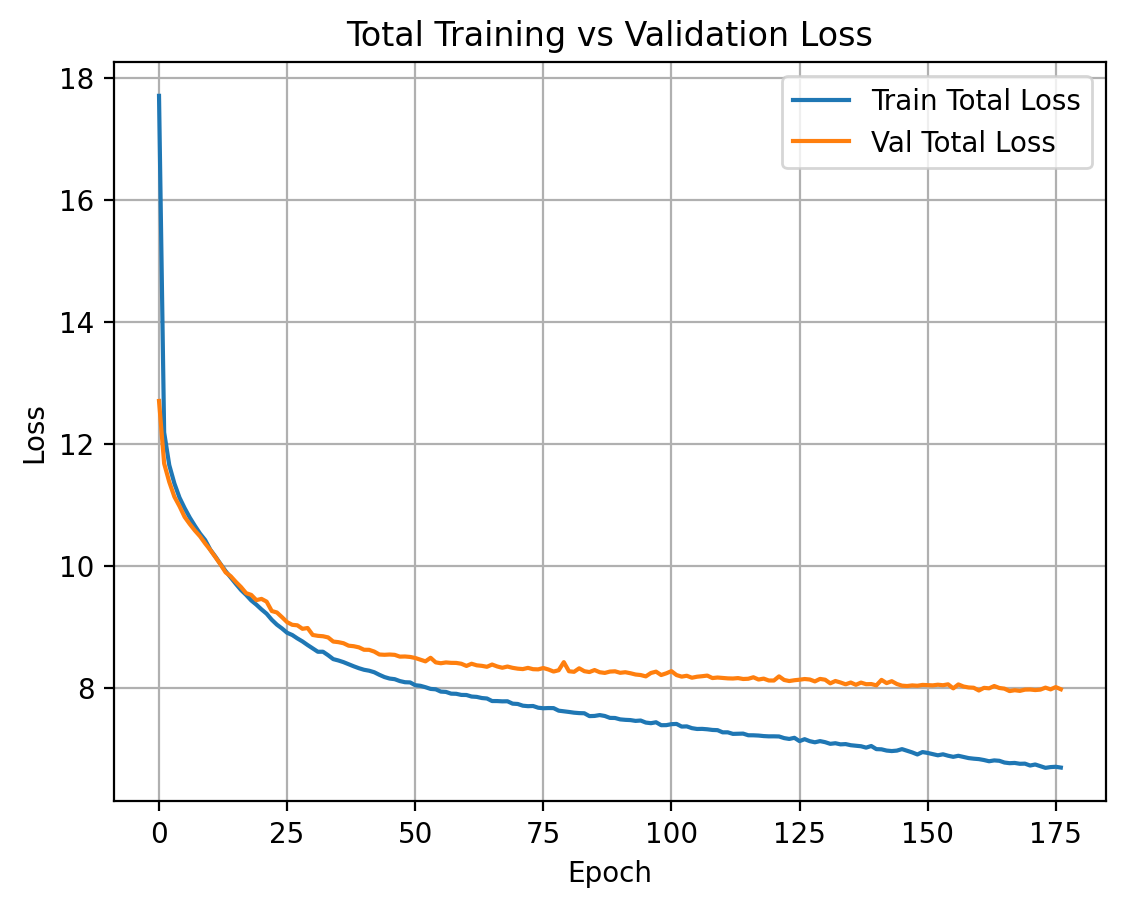

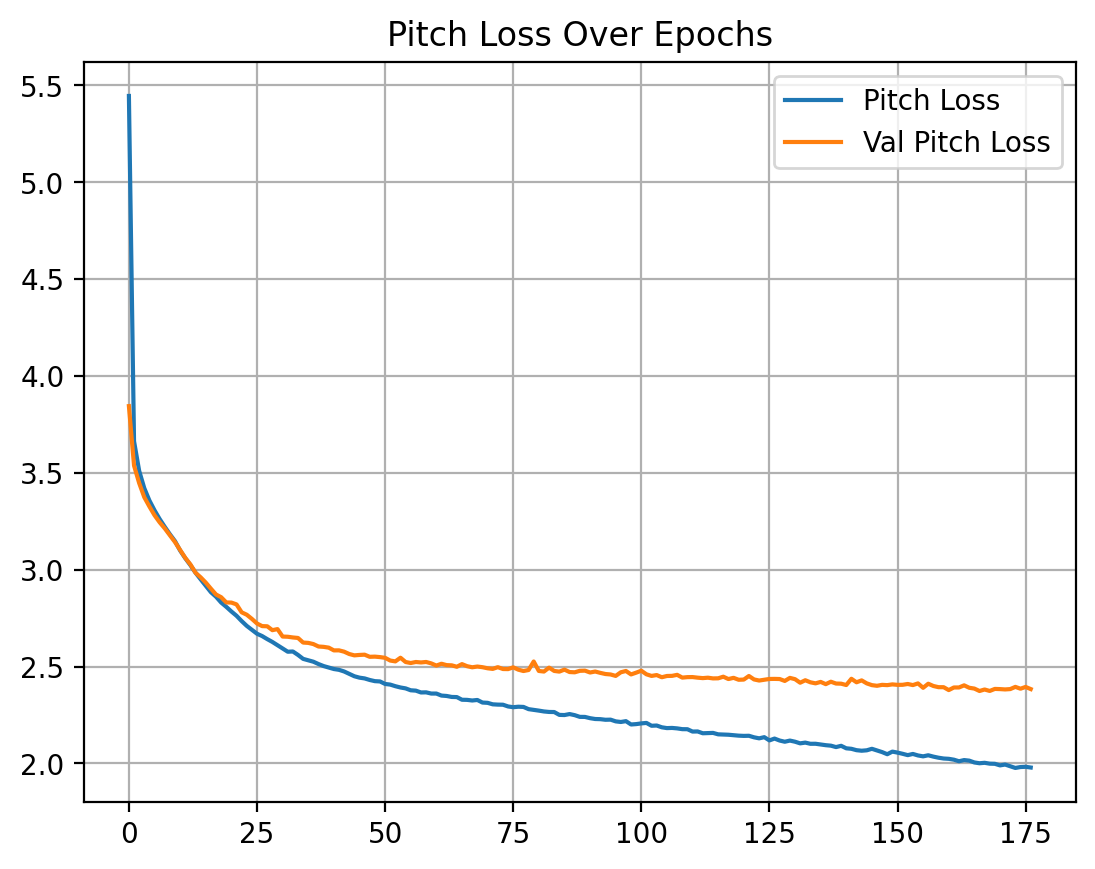

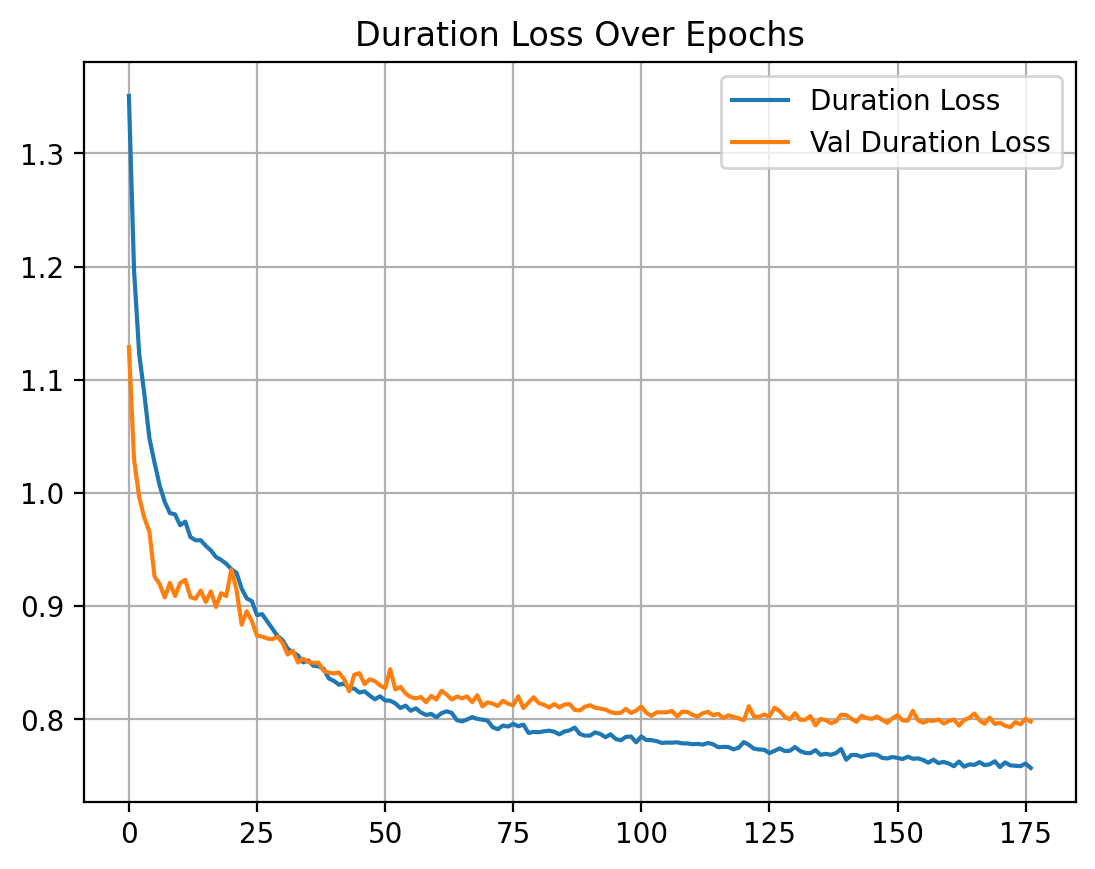

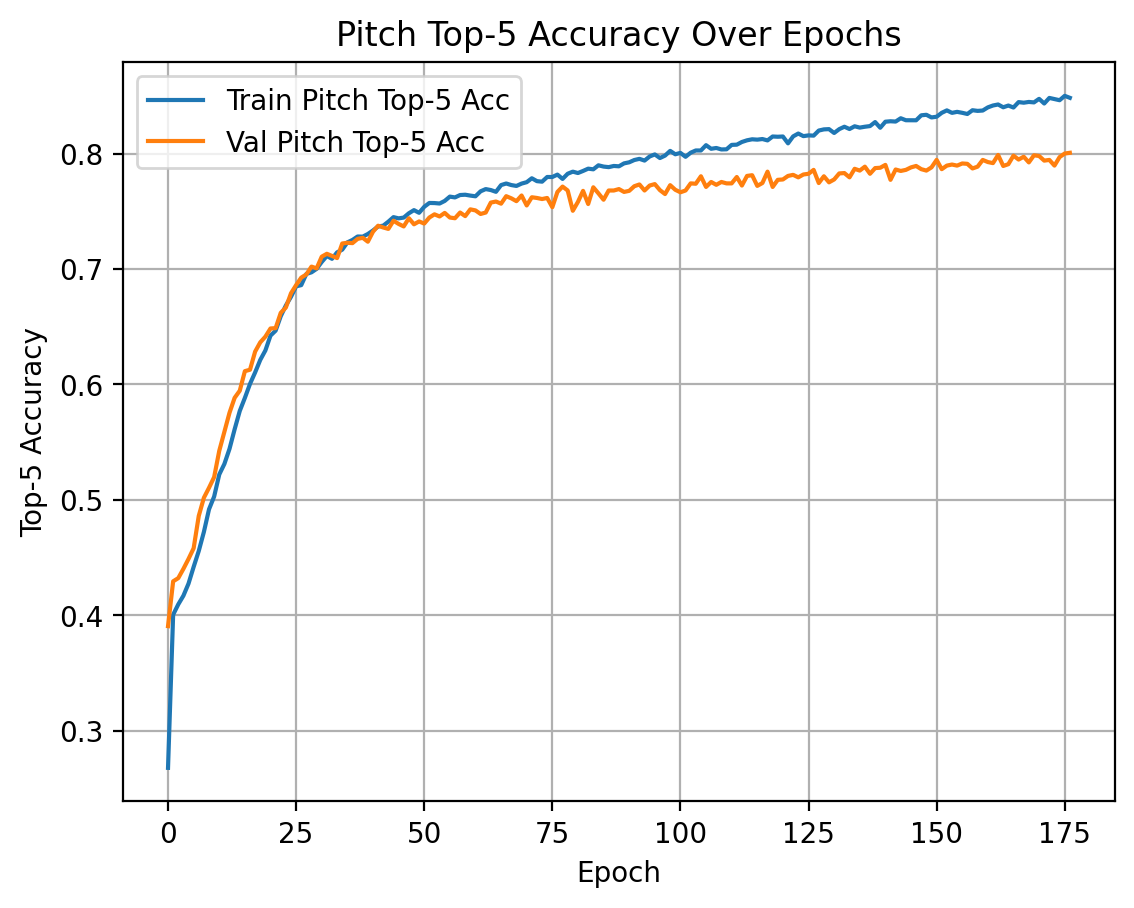

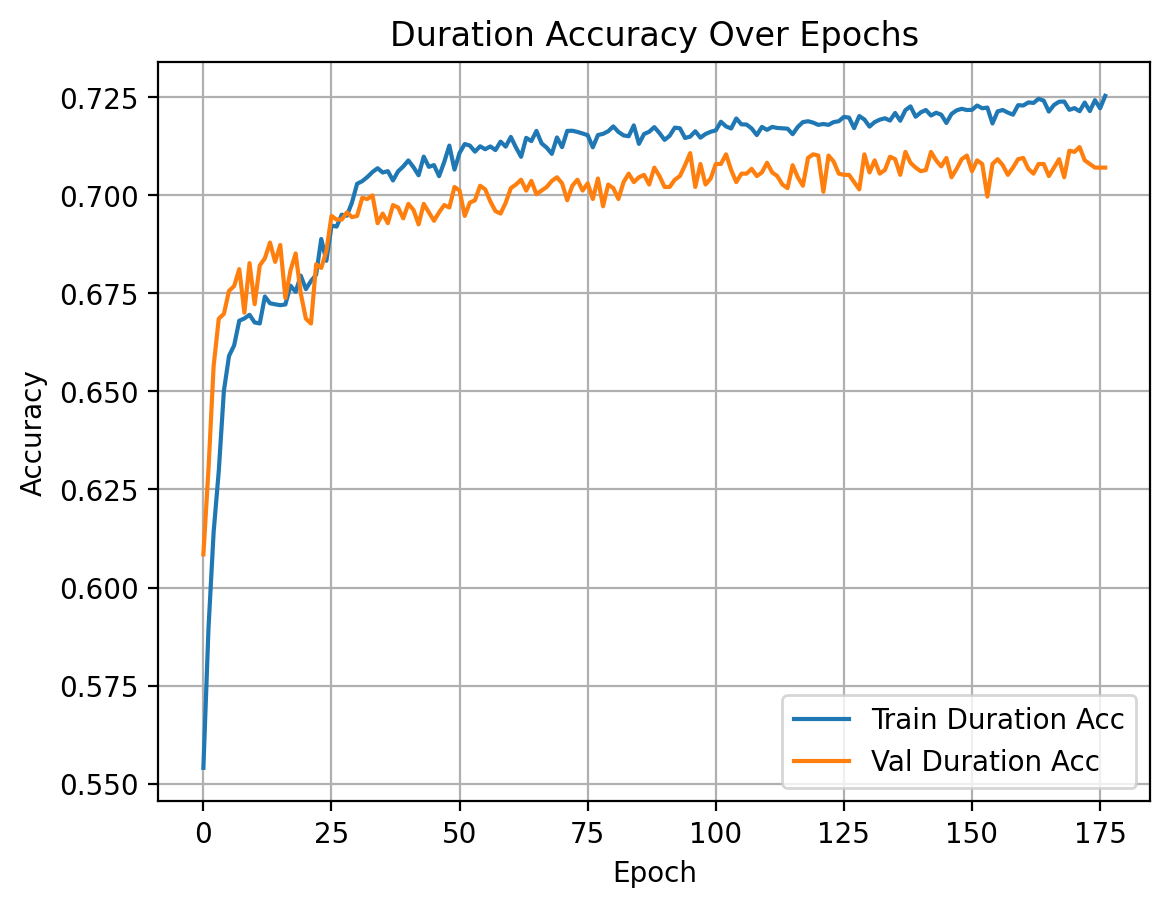

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - duration_output_accuracy: 0.7340 - duration_output_loss: 0.7285 - loss: 7.9723 - pitch_output_loss: 2.4146 - pitch_output_top_k_categorical_accuracy: 0.7837


In [7]:
# total loss results over epochs
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.title("Total Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# pitch loss over epochs
plt.plot(history.history['pitch_output_loss'], label='Pitch Loss')
plt.plot(history.history['val_pitch_output_loss'], label='Val Pitch Loss')
plt.title("Pitch Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# duration loss over epochs
plt.plot(history.history['duration_output_loss'], label='Duration Loss')
plt.plot(history.history['val_duration_output_loss'], label='Val Duration Loss')
plt.title("Duration Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# pitch top k accuracy over epochs
plt.plot(history.history['pitch_output_top_k_categorical_accuracy'], label='Train Pitch Top-5 Acc')
plt.plot(history.history['val_pitch_output_top_k_categorical_accuracy'], label='Val Pitch Top-5 Acc')
plt.title("Pitch Top-5 Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# duration accuracy over epochs
plt.plot(history.history['duration_output_accuracy'], label='Train Duration Acc')
plt.plot(history.history['val_duration_output_accuracy'], label='Val Duration Acc')
plt.title("Duration Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

results = model.evaluate(
    [x_pitch_test, x_dur_test],
    {'pitch_output': y_pitch_test, 'duration_output': y_dur_test},
    verbose=1
)


# Save/Load Model (Optional)

In [8]:
from tensorflow.keras.models import load_model

# model = load_model("lstm_model.h5")     # If loading model 
model.save("lstm_model.h5")           # If saving model




# Generating MIDI output

In [9]:
def sample_with_temperature(preds, temperature=0.8):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def generate_notes(model, pitch_inputs, duration_inputs, int_to_pitch, int_to_duration, n_notes=200, temperature=0.8):
    # Choose a random seed index
    start = np.random.randint(0, len(pitch_inputs) - 1)
    pitch_pattern = pitch_inputs[start].tolist()    # shape: (sequence_length,)
    dur_pattern = duration_inputs[start].tolist()

    generated = []

    for i in range(n_notes):
        # Reshape for model input
        pitch_seq = np.array(pitch_pattern).reshape(1, -1)
        dur_seq = np.array(dur_pattern).reshape(1, -1)

        # Predict
        pitch_probs, dur_probs = model.predict([pitch_seq, dur_seq], verbose=0)

        # Sample next tokens
        pitch_index = sample_with_temperature(pitch_probs[0], temperature)
        dur_index = sample_with_temperature(dur_probs[0], temperature)

        # Map back to pitch/duration
        pitch = int_to_pitch[pitch_index]
        duration = int_to_duration[dur_index]

        generated.append((pitch, duration))

        # Slide window: append new token and drop first
        pitch_pattern = pitch_pattern[1:] + [pitch_index]
        dur_pattern = dur_pattern[1:] + [dur_index]

        # Live progress
        if (i + 1) % 50 == 0 or i == 0:
            print(f"[{i+1}/{n_notes}] Generated: {pitch}_{duration}")

    return generated


In [10]:
def save_midi(prediction_output, output_file="generated_music.mid"):
    offset = 0
    output_notes = []

    for pattern in prediction_output:
        try:
            pitch_part, dur = pattern

            # Chord (contains ".") vs single note
            if '.' in pitch_part:
                chord_notes = []
                for n in pitch_part.split('.'):
                    try:
                        chord_notes.append(note.Note(int(n)))  # MIDI number (e.g., 60)
                    except:
                        chord_notes.append(note.Note(n))       # Named note (e.g., "C4")
                new_chord = chord.Chord(chord_notes)
                new_chord.offset = offset
                new_chord.duration.quarterLength = float(dur)
                new_chord.storedInstrument = instrument.Piano()
                output_notes.append(new_chord)

            else:
                new_note = note.Note(pitch_part)
                new_note.offset = offset
                new_note.duration.quarterLength = float(dur)
                new_note.storedInstrument = instrument.Piano()
                output_notes.append(new_note)

            offset += float(dur)  # natural time spacing

        except Exception as e:
            print(f"Skipping {pattern}: {e}")

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=output_file)
    print(f"✅ MIDI saved to {output_file}")


In [12]:
# Generate new sequence
generated_sequence = generate_notes(
    model=model,
    pitch_inputs=x_pitch_test,
    duration_inputs=x_dur_test,
    int_to_pitch=int_to_pitch,
    int_to_duration=int_to_duration,
    n_notes=100,
    temperature=0.8
)

# Save to MIDI
save_midi(generated_sequence, output_file="generated_music.mid")


[1/100] Generated: C5_0.25
[50/100] Generated: E4_0.25
[100/100] Generated: D4_0.25
✅ MIDI saved to generated_music.mid
